# Random sampling of xarray DataArrays

Testing a workflow for conducting random sampling on post-classification dataarrays

In [1]:
import pandas as pd
import xarray as xr
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import sys
sys.path.append('../Scripts')
from deafrica_plotting import map_shapefile

## Analysis Parameters

In [2]:
total_points = 500

pred_tif = 'results/predicted_12months_255polys_SA.tif'

## Random sampling function

In [3]:
def random_sampling(da,
                    n,
                    sampling='stratified_random',
                    manual_class_ratios=None,
                    out_fname=None
                   ):
    """
    Creates randomly sampled points for post-classification
    accuracy assessment.
    
    Params:
    -------
    da: xarray.DataArray
        A classified 2-dimensional xarray.DataArray
    n: int
        Total number of points to sample. Ignored if providing
        a dictionary of class:numofpoints to 'manual_class_ratios'
    sampling: str
        'stratified_random' = Create points that are randomly 
        distributed within each class, where each class has a
        number of points proportional to its relative area. 
        'equal_stratified_random' = Create points that are randomly
        distributed within each class, where each class has the
        same number of points.
        'random' = Create points that are randomly distributed
        throughout the image.
        'manual' = user definined, each class is allocated a 
        specified number of points, supply a manual_class_ratio 
        dictionary mapping number of points to each class
    manual_class_ratios: dict
        If setting sampling to 'manual', the provide a dictionary
        of type {'class': numofpoints} mapping the number of points
        to generate for each class.
    out_fname: str
        If providing a filepath name, e.g 'sample_points.shp', the
        function will export a shapefile/geojson of the sampling
        points to file.
    
    Output
    ------
    GeoPandas.Dataframe
    
    """
    
    if sampling not in ['stratified_random', 'equal_stratified_random', 'random', 'manual']:
        raise ValueError("Sampling strategy must be one of 'stratified_random', "+
                             "'equal_stratified_random', 'random', or 'manual'") 
    
    #open the dataset as a pandas dataframe
    df = da.to_dataframe(name='class')
    
    #list to store points
    samples = []
    
    if sampling == 'stratified_random':
        #determine class ratios in image
        class_ratio = pd.DataFrame({'proportion': df['class'].value_counts(normalize=True),
                            'class':pd.unique(df['class'])
                                 })
        
        for _class in class_ratio['class']:
            #use relative proportions of classes to sample df
            no_of_points = total_points * class_ratio[class_ratio['class']==_class]['proportion'].values[0]
            #random sample each class
            print('Class '+ str(_class)+ ': sampling at '+ str(round(no_of_points)) + ' coordinates')
            sample_loc = df[df['class'] == _class].sample(n=int(round(no_of_points)))
            samples.append(sample_loc)

    if sampling == 'equal_stratified_random':
        classes = pd.unique(df['class'])
        
        for _class in classes:
            #use relative proportions of classes to sample df
            no_of_points = total_points / len(classes)
            #random sample each class
            print('Class '+ str(_class)+ ': sampling at '+ str(round(no_of_points)) + ' coordinates')
            sample_loc = df[df['class'] == _class].sample(n=int(round(no_of_points)))
            samples.append(sample_loc)
    
    if sampling == 'random':
        no_of_points = total_points
        #random sample entire df
        print('Randomly sampling dataAraay at '+ str(round(no_of_points)) + ' coordinates')
        sample_loc = df.sample(n=int(round(no_of_points)))
        samples.append(sample_loc)
    
    if sampling == 'manual':
        if isinstance(manual_class_ratios, dict):
            #check classes in the array
            classes = pd.unique(df['class'])
            #run sampling
            if [str(i) for i in classes].sort() == list(manual_class_ratios.keys()).sort():
                for _class in classes:
                    #use supplied class:numofpoints dict to sample df
                    no_of_points = manual_class_ratios.get(str(_class))
                    #random sample each class
                    print('Class '+ str(_class)+ ': sampling at '+ str(round(no_of_points)) + ' coordinates')
                    sample_loc = df[df['class'] == _class].sample(n=int(round(no_of_points)))
                    samples.append(sample_loc)

            else:
                raise ValueError("Classes in the 'manual_class_ratio' dictionary do not" +
                                 " match the classes in the supplied dataArray. "+
                                "DataArray classes: "+str(classes)+", Supplied dict classes: "+
                                 str(list(manual_class_ratios.keys())))
            
        else:
            raise ValueError("Must supply a dictionary mapping {'class': numofpoints} if sampling" +
                             " is set to 'manual'")
    
    #join back into single datafame
    all_samples = pd.concat([samples[i] for i in range(0,len(samples))])
        
    #get pd.mulitindex coords as list 
    y = [i[0] for i in list(all_samples.index)]
    x = [i[1] for i in list(all_samples.index)]

    #create geopandas dataframe
    gdf = gpd.GeoDataFrame(
        all_samples,
        crs=da.crs,
        geometry=gpd.points_from_xy(x,y)).reset_index()

    gdf = gdf.drop(['x', 'y'],axis=1)
    
    if out_fname is not None:
        gdf.to_file(out_fname)
    
    return gdf

In [4]:
%%time
gdf = random_sampling(da=xr.open_rasterio(pred_tif).squeeze(),
                        n=total_points,
                        sampling='manual',
                        manual_class_ratios={'1.0': 200, '0.0':300},
                        out_fname=None
                       )

Class 0.0: sampling at 300 coordinates
Class 1.0: sampling at 200 coordinates
CPU times: user 19.1 s, sys: 3.15 s, total: 22.2 s
Wall time: 22.3 s


In [ ]:
gdf.head()

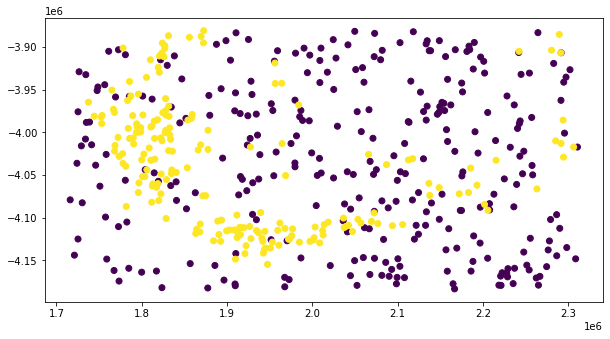

In [5]:
gdf.plot(column='class', figsize=(10,10))